In [1]:
%%capture --no-stderr
!apt install -y wget sox

In [2]:
!pip install -qq python_speech_features scipy pysndfx

In [3]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from python_speech_features import mfcc
import scipy.io.wavfile as scpwav
from zlib import crc32
from pysndfx import AudioEffectsChain
import random
print(tf.__version__)

2.4.1


In [4]:
plt.rc('figure', figsize=(13, 4))

In [5]:
!test -f 'synth.npy' || gunzip 'synth.npy.gz'

In [6]:
dataset = np.load('synth.npy')

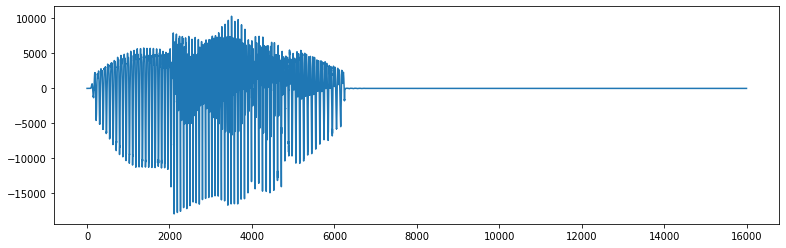

In [7]:
tfdset = tf.data.Dataset.from_tensor_slices(dataset)
tfdset = tfdset.enumerate()
tfdset = tf.data.Dataset.zip((
  tfdset.flat_map(lambda i, a: tf.data.Dataset.from_tensor_slices(a)),
  tfdset.flat_map(lambda i, a: tf.data.Dataset.from_tensors(i).repeat(len(a)))
))
tfdset = tfdset.map(lambda a, i: [a[1:], tf.cast(i, tf.int32), a[0]])
assert plt.plot(list(tfdset.take(1))[0][0].numpy())

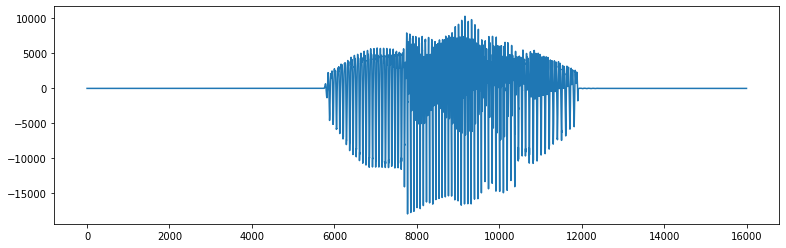

In [8]:
tfdset = tfdset.map(lambda a, i, p: [a, i, p, tf.random.uniform([], 0, p, dtype=tf.int64)])
tfdset = tfdset.map(lambda a, i, p, r: [tf.pad(a[:-p], [[r, p-r]]), i])
assert plt.plot(list(tfdset.take(1))[0][0].numpy())

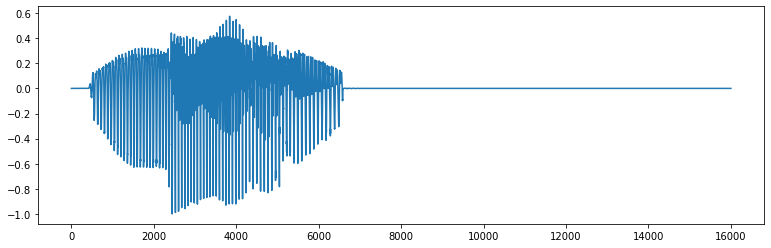

In [9]:
tfdset = tfdset.map(lambda a, i: [tf.cast(a, tf.float32), i])
tfdset = tfdset.map(lambda a, i: [a, i, tf.abs(a)])
tfdset = tfdset.map(lambda a, i, s: [a, i, tf.reduce_max(s)])
tfdset = tfdset.map(lambda a, i, m: [a / m, i])
assert plt.plot(list(tfdset.take(1))[0][0].numpy())

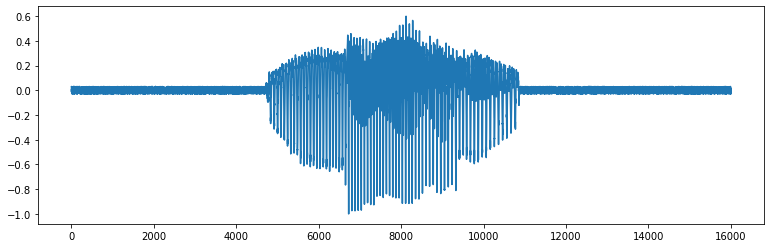

In [10]:
tfdset = tfdset.map(lambda a, i: [a, i, tf.random.uniform([], 0, 0.05)])
tfdset = tfdset.map(lambda a, i, r: [a, i, tf.random.uniform([len(a)], -r, r)])
tfdset = tfdset.map(lambda a, i, n: [tf.add(a, n), i])
assert plt.plot(list(tfdset.take(1))[0][0].numpy())

In [11]:
def gh_fetch_ds(id, md5):
  !wget -qN "https://github.com/42io/dataset/releases/download/v1.0/$id"
  stdout = !md5sum "$id"
  assert md5 == stdout[0].split()[0], stdout
  !tar xf "$id" -C 'ds_wav'

if not tf.io.gfile.exists('ds_wav'):
  tf.io.gfile.mkdir('ds_wav')
  gh_fetch_ds('pub.tar.bz2', '46d5866d6ce5ad53eded3b197f189869')
  gh_fetch_ds('unk.tar.gz',  '809a733a42375feea2cd57de1aa27837')

In [12]:
shuffle_buffer_size = sum(len(x) for x in dataset)
unk_pub_category_size = shuffle_buffer_size // len(dataset)

In [13]:
def load_wav_dset(pattern, category, shuf_sz=92020):
  dset = tf.data.Dataset.list_files(pattern, shuffle=False)
  dset = dset.shuffle(shuf_sz)
  dset = dset.take(unk_pub_category_size)
  dset = dset.map(lambda p: tf.io.read_file(p))
  dset = dset.map(lambda f: tf.audio.decode_wav(f)[0])
  dset = dset.map(lambda a: tf.squeeze(a, -1))
  dset = dset.map(lambda a: [a, category])
  return dset

In [14]:
tfdset_unk = load_wav_dset('ds_wav/*/#unk#/*.wav', len(dataset))
tfdset_pub = load_wav_dset('ds_wav/*/#pub#/*.wav', len(dataset) + 1)

In [15]:
tfdset = tfdset.concatenate(tfdset_unk)
tfdset = tfdset.concatenate(tfdset_pub)

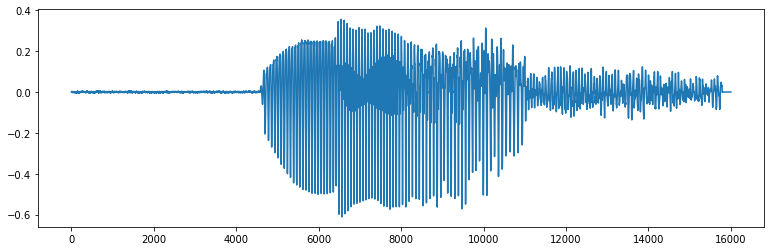

In [16]:
def augment(x):
    fx = AudioEffectsChain()

    if random.random() < 0.2:
      fx = fx.highshelf()
  
    if random.random() < 0.5:
      fx = fx.reverb(random.randint(0, 50), 
                     random.randint(0, 50), 
                     random.randint(0, 100))

    if random.random() < 0.8:
      fx = fx.pitch(random.randint(-200, 200))

    if random.random() < 0.2:
      fx = fx.phaser()

    if random.random() < 0.2:
      fx = fx.lowshelf()

    return fx(x.numpy())[:16000]

tfdset = tfdset.map(lambda a, i: [tf.py_function(augment, [a], tf.float32), i])
assert plt.plot(list(tfdset.take(1))[0][0].numpy())

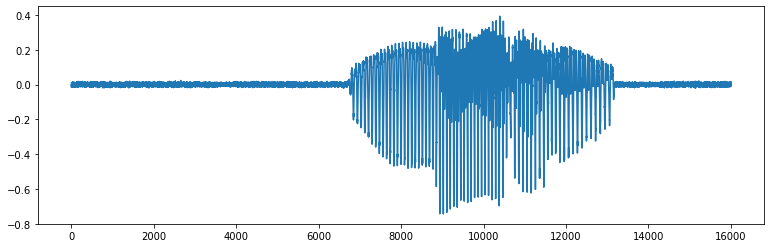

In [17]:
tfdset = tfdset.map(lambda a, i: [a, i, tf.random.uniform([], 0.2, 1)])
tfdset = tfdset.map(lambda a, i, r: [a * r * r, i])
tfdset = tfdset.map(lambda a, i: [tf.clip_by_value(a, -1, 1), i])
assert plt.plot(list(tfdset.take(1))[0][0].numpy())

In [18]:
for i, j in enumerate(np.cumsum([0] + [len(x) for x in dataset] + [unk_pub_category_size])):
  pair = list(tfdset.skip(j).take(1))[0]
  ipd.display(ipd.Audio(pair[0].numpy(), rate=16000, normalize=False))
  assert pair[1] == i, pair[1].numpy()

In [19]:
def fe(a):
  assert a.dtype == tf.int16
  return mfcc(a.numpy(), 16000, winlen=0.05, winstep=0.02, nfft=1024)

In [20]:
%%capture --no-stderr
crc = 'ds_wav/training/#unk#/house_37bd115d_nohash_0.wav'
crc = scpwav.read(crc)[1]
crc = tf.data.Dataset.from_tensors(crc)
crc = crc.map(lambda a: tf.py_function(fe, [a], tf.float64))
crc = list(crc)[0].numpy()
for a in crc:
   print(" ".join("%9.5f" % x for x in a))
crc = crc.tobytes()
crc = crc32(crc)
assert 0x6289b478 == crc, hex(crc)

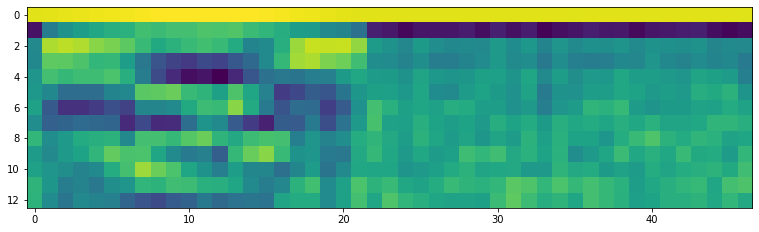

In [21]:
tfdset = tfdset.map(lambda a, i: [a * 32767, i])
tfdset = tfdset.map(lambda a, i: [tf.cast(a, tf.int16), i])
tfdset = tfdset.map(lambda a, i: [tf.py_function(fe, [a], tf.float64), i])
tfdset = tfdset.map(lambda a, i: [a[1:-1], i])
assert plt.imshow(list(tfdset.take(1))[0][0].numpy().T)

In [22]:
shuffle_buffer_size += 2 * unk_pub_category_size
validation_size = shuffle_buffer_size // 10

In [23]:
batch_size = 32
tfdset   = tfdset.shuffle(shuffle_buffer_size, reshuffle_each_iteration=False)
tfdset   = tfdset.map(lambda a, i: [tf.expand_dims(a, -2), i])
tfdset   = tfdset.prefetch(tf.data.AUTOTUNE)
valid_ds = tfdset.take(validation_size)
valid_ds = valid_ds.batch(batch_size)
train_ds = tfdset.skip(validation_size)
train_ds = train_ds.shuffle(shuffle_buffer_size - validation_size)
train_ds = train_ds.batch(batch_size)

In [24]:
# https://arxiv.org/pdf/2005.06720.pdf

def streaming_input_output(streaming, t, inputs, otputs, x):
  if streaming:
    otputs.append(x)
    x = keras.Input(shape=[t] + x.shape[2:])
    inputs.append(x)
  return x

def build_model(streaming=False):

  # resetting the layer name generation counter
  keras.backend.clear_session()

  inputs  = []
  outputs = []

  x = x_in = keras.Input(shape=[1 if streaming else 47, 1, 13])

  x = keras.layers.Conv2D(64, 1, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)

  for i in range(4):
    x = streaming_input_output(streaming, 2, inputs, outputs, x)
    x = keras.layers.SeparableConv2D(x.shape[-1], kernel_size=[2, 1], 
                                     dilation_rate=[1 if streaming else 2**i, 1], 
                                     use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

  x = streaming_input_output(streaming, 32, inputs, outputs, x)
  x = keras.layers.AveragePooling2D([x.shape[1], 1])(x)
  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(x.shape[-1] // 2, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)

  x = keras.layers.Dense(len(dataset) + 2, activation='softmax')(x)

  model = keras.Model(inputs=[x_in] + inputs, outputs=[x] + outputs)

  return model

In [25]:
model = build_model()
for i in range(len(model.layers) - 1):
  model.layers[i].trainable = False

model.load_weights('embedding.weights.h5', by_name=True)

model.summary()

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 47, 1, 13)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 47, 1, 64)         832       
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 1, 64)         256       
_________________________________________________________________
re_lu (ReLU)                 (None, 47, 1, 64)         0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 46, 1, 64)         4224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 1, 64)         256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 46, 1, 64)         0     

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=100,
        restore_best_weights=True)

history = model.fit(train_ds,
                    validation_data=valid_ds,
                    callbacks=[early_stopping],
                    verbose=2,
                    epochs=100500)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


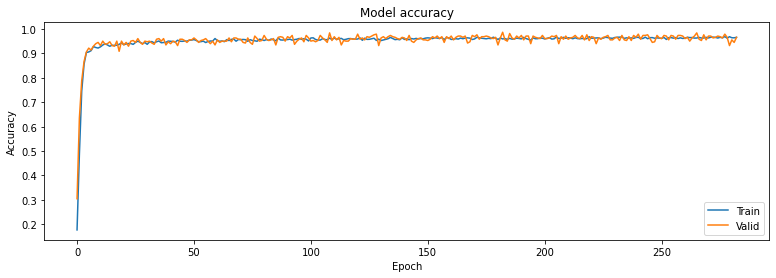

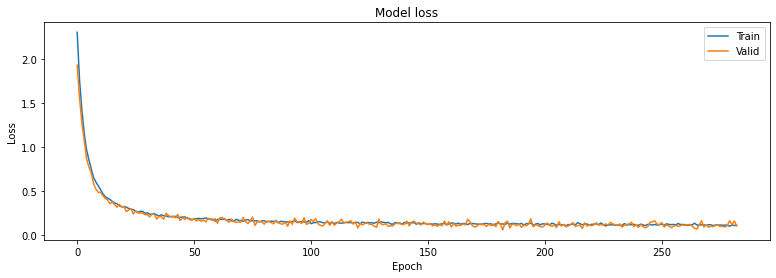

In [27]:
print(history.history.keys())

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [28]:
stream_model = build_model(True)

stream_model.summary()

# copy weights from old model to new one
for layer in stream_model.layers:
    if layer.get_weights():
      print("Transfer weights for layer {}".format(layer.name))
      layer.set_weights(model.get_layer(name=layer.name).get_weights())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 1, 64)]  0                                            
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 1, 1, 64)     0           input_6[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 64)           0           average_pooling2d[0][0]          
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           2048        flatten[0][0]                    
______________________________________________________________________________________________

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(stream_model)
converter.experimental_new_converter = False
tflite_model = converter.convert()
with open("dcnn.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp1obl8b20/assets


In [30]:
!md5sum 'dcnn.tflite'

58b4dcd02e940aeac6a2c05c45acad8f  dcnn.tflite
